# Info

Argon Jennard-Jones systems

## Targets
* create a toy system with python.
    * create a `system`
    * create a `force`
    * create a `topology`

In [1]:
from simtk import openmm as mm
from simtk.openmm import app
from simtk.unit import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Input

Let's define us an argon system.

## Interactions

First, we need to define some general parameters like `mass`, `charge` and the Lennard-Jones parameters `sigma` and `epsilon`.

In [2]:
mass = 39.9 * amu
charge = 0.0 * elementary_charge
sigma = 3.4 * angstroms
epsilon = 0.238 * kilocalories_per_mole

## System parameter

Secondly, we need to define the basics of our system, namely, the volume via `box_size` and the number of particles `n_particles`.

In [3]:
n_particles = 512
box_size = 50 * angstrom

# Build the simulation

Let's build our `Simulation` object.

For this we need a `system`, `integrator` and `toplogy`.

## Create the system

The first step in defining a `system` is to define particles with a given `mass` in the system.

We can add these with `system.addParticle(mass)`.

In [4]:
# Create a system and add particles to it
system = mm.System()
for index in range(n_particles):
    # Particles are added one at a time
    # Their indices in the System will correspond with their indices in the Force objects we will add later
    system.addParticle(mass)

## Create the box

If we do not want to do our simulation in a non-periodic box, we need to define the box it self.

This is be done by defining the `box_vectors` spanning the box.

In [5]:
box_vectors = np.diag([box_size/angstrom for i in range(3)])*angstrom
system.setDefaultPeriodicBoxVectors(*box_vectors)

## Define interactions

If we do not want to simulate an ideal gas, we need some interactions in our system.

We can add non-bonded interactions by using `openmm.NonbondedForce()`. This will create a `force` with Lennard-Jones **and** Coulomb interactions.

We have to add **all** particles to the force. After we have define other parameters we can add this force to our system with `system.addForce(force)`.

In [6]:
# Add Lennard-Jones interactions using a NonbondedForce
force = mm.NonbondedForce()
force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)

In [7]:
# all particles must have parameters assigned for the NonbondedForce
for index in range(n_particles): 
    # Particles are assigned properties in the same order as they appear in the System object
    force.addParticle(charge, sigma, epsilon)

In [8]:
force.setCutoffDistance(3.0 * sigma) # set cutoff (truncation) distance at 3*sigma
force.setUseSwitchingFunction(True) # use a smooth switching function to avoid force discontinuities at cutoff
force.setSwitchingDistance(2.5 * sigma) # turn on switch at 2.5*sigma
force.setUseDispersionCorrection(True) # use long-range isotropic dispersion correction

force_index = system.addForce(force) # system takes ownership of the NonbondedForce object

## create an integrator

As we want to do a simulation and update our positions and velocities we need to add an `integrator` to our simulation.

In this case, we will use a the **leap-frog integrator** by using `openmm.VerletIntegrator(timestep)`.

In [9]:
# Create an integrator
timestep = 1.0 * femtoseconds
integrator = mm.VerletIntegrator(timestep)

## Create the toplogy

At this point we can just create a `context` via 
```python
context = openmm.Context(system, integrator, platform)
```

but since we want to use the `Simulation` object (for all the nice features it comes with) we first have to create a `Topology`.

It needs a `chain` and a `residue` to add an atom to it.

The following code will create 1 `chain` and add all atoms a single `residues` to the `Topology`.

In [10]:
top = app.Topology()
chain = top.addChain()
for i in range(n_particles):
    residue = top.addResidue(name='Ar', chain=chain, id=i)
    top.addAtom('Ar',element=app.Element.getBySymbol('Ar') , residue=residue)
top.setPeriodicBoxVectors(box_vectors)
print(top) 

<Topology; 1 chains, 512 residues, 512 atoms, 0 bonds>


## create the simulation

Now we have all ingredients to create a `Simulation` object.

Note: the `integrator` is bound to the `Simulation` object and can **not** be reused in an other object. Hence, it has to be recreated.

In [11]:
simulation = app.Simulation(topology=top, system=system, integrator=integrator)

## Define starting positions of the Lennard-Jones particles

Of cause we need positions to describe our system, as we have no idea about how a gas looks like, we create them as random positions using `np.random.rand(n_particles, 3) ` to create a uniform distribution of particles.

Note: we have to scale it to the box size as we get numbers between `0` to `1`.

We can then set the coordinates of our simulation using `simulation.context.setPositions(positions)`.

In [12]:
positions = box_size * np.random.rand(n_particles, 3) 
positions

Quantity(value=array([[  0.9646983 ,  31.9609628 ,   6.92385496],
       [ 35.94451885,  45.95133804,  40.30506597],
       [ 17.92966414,  35.61744372,   4.41692426],
       ..., 
       [ 18.28146122,  37.83716023,  35.35814006],
       [ 22.04218763,  19.0612215 ,  37.60780437],
       [ 18.63043932,  44.17030419,   4.59178845]]), unit=angstrom)

In [13]:
simulation.context.setPositions(positions)

# Run the simulation

Now we are ready to go to do a simulation.

But, there are a few things which have to be done first.
* minimize the system
* write output
* set velocities

## Minimize

We have to minimize the system to avoid an overlap of atoms.

In [14]:
simulation.minimizeEnergy()

## Add reporter for the output

We have to add `reporters` to the `simulation` to generate output otherwise we can simulate the system but wont be able to follow it. You can easily add `reporters` by `append` them to the list `simulation.reporters`.

In [15]:
simulation.reporters.append(app.StateDataReporter('thermo.argon.csv', 100,
                                                  step=True,
                                                  potentialEnergy=True,
                                                  kineticEnergy=True,
                                                  totalEnergy=True,
                                                  temperature=True,
                                                 ))

In [16]:
simulation.reporters.append(app.DCDReporter("trajectory.argon.dcd", 100, enforcePeriodicBox=True))

## set velocities

We want to set a starting temperature for our simulation. We can do this by either using `simulation.context.setVelocitiesT(velocities)` or `simulation.context.setVelocitiesToTemperature(temperature)`. The first uses a `(n_particles, 3)` array and sets these velocities the later creates velocities for a given `temperature`.

In [17]:
simulation.context.setVelocitiesToTemperature(300 * kelvin)

## Run the simulation

Now, we can finally run the simulation by using `simulation.step(n_steps)` to run it for `n_steps`.

In [18]:
simulation.step(10000)

# Visualize the simulation

This part is now no longer about simulation it self but just about a quick visualization in the `jupyter-notebook`.
Of cause you can also use your favorite viewer to have a look at the trajectory.

e.g for VMD:
```tcl
vmd > set n_particles 512
vmd > mol new atoms ${n_particles}
vmd > mol representation VDW 1.0 12
vmd > mol addrep top
vmd > mol addfile trajectory.argon.dcd waitfor all
```

Load `mdtraj` and `nglview` to load the trajectory and render it.

In [19]:
import mdtraj
import nglview

Load the trajectory.

Note: we can use `mdtraj.Topology.from_openmm(simulation.topology)` to directly get the trajectory from the OpenMM `simulation` object.

In [20]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.argon.dcd', mdtraj_topology)

Visualize it.

In [21]:
view = nglview.show_mdtraj(traj) # gui=True for more options

# view.add_ball_and_stick('all') # smaller balls
view.add_representation("spacefill")
view.add_unitcell()
# update camera type
view.camera = 'orthographic'

view.center()
view

NGLWidget(count=100)

# Analysis of thermodynamics

Let's have a first look into our `csv` file. 

In [22]:
# print the first line of the file
print(open('thermo.argon.csv', 'r').readline())

#"Step","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Total Energy (kJ/mole)","Temperature (K)"



As you can see, the properties are listed with the corresponding unit.

You can easily load a `csv` file using `np.genfromtxt(filename, delimiter=',')`.

A good practice for handling these files is to use the `names=True` argument.
This will assign the column names to the fields of the numpy array.
Now, you can no longer use indices as `data[0]` for the first entry but have to use `data['Potential_Energy_kJmole']` as in dictionaries. 
This may seems stupid at the beginning, but as the order of columns changes dependent on what you save into them, it is the best way to ensure to get the correct files.
It also improves readability of the code!


In [26]:
csv = np.genfromtxt('thermo.argon.csv', delimiter=',', names=True)
print("Fields : {}".format(csv.dtype.names))

Fields : ('Step', 'Potential_Energy_kJmole', 'Kinetic_Energy_kJmole', 'Total_Energy_kJmole', 'Temperature_K')


Let's plot something.

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

Text(0, 0.5, 'Potential Energy [kj/mole]')

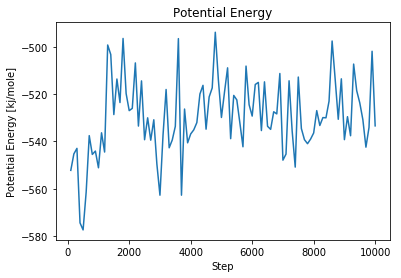

In [28]:
plt.title('Potential Energy')

plt.plot(csv['Step'], csv['Potential_Energy_kJmole'])

plt.xlabel('Step')
plt.ylabel('Potential Energy [kj/mole]')

Text(0, 0.5, 'Temperature [K]')

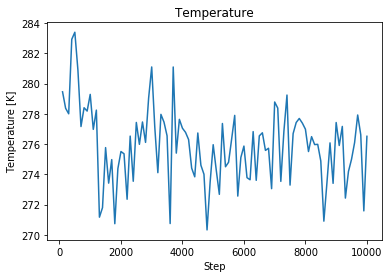

In [29]:
plt.title('Temperature')

plt.plot(csv['Step'], csv['Temperature_K'])

plt.xlabel('Step')
plt.ylabel('Temperature [K]')